# The `pointset` class

The `pointset` class maintains a sorted list of vertices along with their adjacancies.
This class is designed to support triangulations.
In particular it supports creating a Delaunay triangulation,
which has the property that the circumcircle of any triangle in the triangulation contains 
no other vertices in its _interior_.
The triangulation is not unique when 4 or more points are on cocircular - for
example any regular polygon.
It also maximizes the minimum angle of all the angles of the triangles in the triangulation.
It does not minimize the maximum angle, nor the length of the edges.
The Delaunay triangulation contains the minimum spanning tree.

Delaunay triangulations are useful in a variety of applications.
Computation of it is $O(n\ log\ n)$.
Named after Boris Delaunay for his work in the 1930s.
The dual graph of the Delaunary triangulation is a Voronoi diagram (or Dirichlet or Thiessen tesselation),
which partitions the plane by mapping every point to the nearest vertex in the triangulation.

Each vertex has an associated adjacancy list.
Each adjacancy list is always ordered in a counter clockwise orientation
around the given vertex.
If the vertex is on the convex hull boundary, then the first vertex on the adjacancy list is the next counter clockwise vertex on the boundary.
This feature prevents full support of collinear points.
Specifically, it cannot merge 2 triangles that are collinear.
**In a collinear triangle, the middle vertex has 2 different counter clockwise vertices on the convex hull boundary.**

In addition to these primary attributes, the class maintains a set of options that control the runtime output.

The code is organized as follows:
- [Preliminaries](#Preliminaries) including imports
- [References](#References) articles and papers that help explain the processing
- [pointset](#pointset-class) the definition of the `pointset` class
- [Graph Operations](#Graph-Operations) the a operations on the triangulation.
- [Conversion](#Convert-notebook-to-Python-module) for creating the python module.
- [Final Thoughts](#Final-Thoughts) for final thoughts.

The Delauney triangulation consists of the following core code methods:
- [Primitives](#Primitives): `is-right-of` and `circumcircle`
- [Convex Hull](#Convex Hull): `chuct` and `chlct` for calculating the upper and lower common tangents of 2 convex hulls.
- [Triangulation](#Triangulation): `merge` to combine two triangulations and `insert` to update the adjacancy lists

The class definition only contains the constructor method.
As additional methods in the class are added they are tested with sample output.
These cells in the notebook are tagged as `test`.
I use the generic name `method` to define a function and then attach the function to a class method name.
At the end of the class definition the name `method` is deleted.

Finally, the notebook itself is converted to a python module by excluding the `test` cells.

## References

D. T. Lee and B. J. Schachter,
["Two Algorithms for Constructing a Delaunay Triangulation"](https://link.springer.com/article/10.1007/BF00977785).
International Journal of Computer and Information Sciences, Vol. 9, No. 3, 1980, pages 219-242.
[search](https://www.google.com/search?q=D.+T.+Lee+and+B.+J.+Schachter%2C+"Two+Algorithms+for+Constructing+a+Delaunay+Triangulation".+International+Journal+of+Computer+and+Information+Sciences%2C+Vol.+9%2C+No.+3%2C+1980)

Guibas, L. and Stolfi, J.,
["Primitives for the Manipulation of General Subdivisions and the Computation of Voronoi Diagrams"](https://dl.acm.org/citation.cfm?id=282923),
ACM Transactions on Graphics, Vol.4, No.2, April 1985, pages 74-123.
[search](https://www.google.com/search?q=Guibas%2C+L.+and+Stolfi%2C+J.%2C+%22Primitives+for+the+Manipulation+of+General+Subdivisions+and+the+Computation+of+Voronoi+Diagrams%22%2C+ACM+Transactions+on+Graphics%2C+Vol.4%2C+No.2%2C+April+1985)

Wikipedia.
[Circumscribed Circle](https://en.wikipedia.org/wiki/Circumscribed_circle)
[Delaunay Triangluation](https://en.wikipedia.org/wiki/Delaunay_triangulation)

Liotta, G.,
["Low Degree Algorithms for Computing and Checking Gabriel Graphs"](ftp://ftp.cs.brown.edu/pub/techreports/96/cs96-28.pdf),
Department of Computer Science, Brown University, CS-96-28, October 1996

## Preliminaries

Import packages. This class only has a few external dependencies.
The `pyplot` imports are only used for plotting.

In [1]:
from random import random
from matplotlib.pyplot import figure, show, Circle, scatter, text

## pointset class

In [2]:
class pointset:
    """
    Provides operations on points used in triangulation.
    
    Points are sorted by x, y. a, the adjacancy graph has an entry for each point.
    If a point is on the convex hull, then the first element is the first point in the counter clockwise direction.
    vertexes in a are sorted in counter clockwise order.
    
    Attributes
    ----------
    x - x positions
    y - y positions
    a - adjacancies
    ha - heirarchy of adjacancies
    
    Additional Attributes
    ---------------------
    options - runtime reporting options
    """
    
    def set_points(self, points):
        points = sorted(points)
        self.npoints = len(points)
        self.x = [x for x, y in points]
        self.y = [y for x, y in points]
        for i in range(self.npoints-1):
            for j in range(i+1, self.npoints):
                if self.x[i] == self.x[j] and self.y[i] == self.y[j]:
                    raise RuntimeError('Points are not unique: {} and {}'
                                       .format( (self.x[i], self.y[i]), (self.x[j], self.y[j]) ))
        self.a = [[] for _ in range(self.npoints)]
        self.ha = None
        return
    
    def __init__(self, n=10, pts=None, delta=None, name=None):
        """
        Generates a random pointset of length n.
        
        if delta is given, the points be delta distance apart.
        """
        if pts != None:
            pass
        elif name != None:
            if name not in pointset.SAMPLES:
                raise ValueError('Unknown pointset: {}'.format(name))
            pts = pointset.SAMPLES[name]
        elif delta != None:
            pts = []
            for _ in range(n):
                maxiter = int(2.0 / delta)
                valid = False
                for _ in range(maxiter):
                    q = random(), random()
                    close = False
                    for p in pts:
                        if ( (p[0] - q[0])**2 + (p[1] - q[1])**2 )**0.5 < delta:
                            close = True
                            break
                    if close == False:
                        valid = True
                        break
                if valid:
                    pts.append(q)
        else:
            pts = [(random(), random()) for _ in range(n)]
        self.set_points(pts)
        self.options = set()
        return

In [3]:
pointset.SAMPLES = {
    # Random points of a given size
    'rnd10': [(+0.015, +0.346), (+0.057, +0.991), (+0.117, +0.670), (+0.183, +0.006), (+0.394, +0.935), (+0.401, +0.315), (+0.724, +0.384), (+0.784, +0.066), (+0.789, +0.821), (+0.988, +0.560)],
    'rnd8': [ (+0.057, +0.991), (+0.117, +0.670), (+0.183, +0.006), (+0.394, +0.935), (+0.401, +0.315), (+0.724, +0.384), (+0.784, +0.066), (+0.789, +0.821)],
    'rnd7': [ (+0.057, +0.991), (+0.117, +0.670), (+0.183, +0.006), (+0.394, +0.935), (+0.401, +0.315), (+0.724, +0.384), (+0.784, +0.066)],
    'rnd6': [ (+0.117, +0.670), (+0.183, +0.006), (+0.394, +0.935), (+0.401, +0.315), (+0.724, +0.384), (+0.784, +0.066)],
    'rnd5': [(+0.015, +0.346), (+0.117, +0.670), (+0.394, +0.935), (+0.724, +0.384), (+0.789, +0.821)],
    'rnd4': [(+0.015, +0.346), (+0.117, +0.670), (+0.394, +0.935), (+0.724, +0.384)],
    'rnd3': [(+0.117, +0.670), (+0.394, +0.935), (+0.724, +0.384)],
    'rnd2': [(+0.117, +0.670), (+0.394, +0.935)],
    # US Capitals
    'usc50': [(0.781,0.424), (0.289,0.689), (0.518,0.435), (0.719,0.448), (0.422,0.487), (0.590,0.499), (0.920,0.520), (0.891,0.493), (0.802,0.404), (0.801,0.438), (0.050,0.311), (0.475,0.539), (0.747,0.500), (0.783,0.500), (0.706,0.518), (0.685,0.492), (0.796,0.484), (0.732,0.404), (0.950,0.546), (0.881,0.491), (0.937,0.525), (0.799,0.530), (0.712,0.553), (0.741,0.423), (0.721,0.487), (0.518,0.569), (0.675,0.510), (0.439,0.493), (0.932,0.535), (0.899,0.504), (0.580,0.458), (0.909,0.529), (0.859,0.459), (0.633,0.592), (0.815,0.502), (0.666,0.456), (0.406,0.552), (0.877,0.505), (0.933,0.521), (0.835,0.441), (0.638,0.547), (0.776,0.463), (0.664,0.403), (0.519,0.510), (0.921,0.546), (0.871,0.477), (0.407,0.574), (0.829,0.485), (0.749,0.533), (0.592,0.514)],
    'usc48': [(0.671,0.379), (0.235,0.397), (0.569,0.419), (0.076,0.483), (0.355,0.503), (0.901,0.538), (0.853,0.494), (0.705,0.346), (0.703,0.402), (0.165,0.569), (0.614,0.504), (0.673,0.504), (0.547,0.535), (0.512,0.492), (0.695,0.477), (0.589,0.347), (0.950,0.581), (0.836,0.490), (0.929,0.546), (0.700,0.554), (0.556,0.591), (0.605,0.378), (0.571,0.484), (0.236,0.619), (0.495,0.521), (0.105,0.494), (0.920,0.562), (0.866,0.512), (0.338,0.435), (0.882,0.553), (0.800,0.436), (0.426,0.657), (0.726,0.507), (0.481,0.431), (0.050,0.591), (0.830,0.512), (0.922,0.539), (0.760,0.406), (0.433,0.582), (0.662,0.443), (0.477,0.343), (0.238,0.521), (0.903,0.580), (0.820,0.466), (0.052,0.627), (0.749,0.480), (0.618,0.560), (0.358,0.527)],
    # Collinear
    'vline3': [(0.25, 0.00), (0.25, 0.25), (0.25, 0.50)],
    'vline4': [(0.25, 0.00), (0.25, 0.25), (0.25, 0.50), (0.25, 0.75)],
    'vline5': [(0.25, 0.00), (0.25, 0.25), (0.25, 0.50), (0.25, 0.75), (0.25, 1.00)],
    'hline3': [(0.00, 0.25), (0.25, 0.25), (0.50, 0.25)],
    'hline4': [(0.00, 0.25), (0.25, 0.25), (0.50, 0.25), (0.75, 0.25)],
    'hline5': [(0.00, 0.25), (0.25, 0.25), (0.50, 0.25), (0.75, 0.25), (1.00, 0.25)]
}

We can create an object of this class using a standard example, a random set, or random points with at least $\delta$ distance between them.

In [4]:
pts = pointset()
pts

In [5]:
pointset.FMT = '({:+.3f}, {:+.3f})'

def method(self):
    """Display a reasonable representation of the pointset"""
    return '[' + ', '.join([str(pointset.FMT.format(self.x[i], self.y[i])) for i in range(self.npoints)]) + ']'

pointset.__repr__ = method
pointset.__str__ = method

Now we can see a more readable value for pointsets.

In [6]:
pts

[(+0.094, +0.498), (+0.110, +0.187), (+0.330, +0.850), (+0.449, +0.609), (+0.551, +0.184), (+0.612, +0.564), (+0.660, +0.582), (+0.714, +0.840), (+0.719, +0.937), (+0.945, +0.309)]

The `log` method will only display output if the log option has been set.

In [7]:
def method(self, str):
    """runtime log messages are only print if the 'log' option is set."""
    if 'log' in self.options:
        print(str)
    return

pointset.log = method

In [8]:
pts.options.add('log')
pts.log('Number of vertices: {}'.format(pts.npoints))

Number of vertices: 10


A plot of the vertices would be more useful.
Since the points are in the unit square, I'll set up a standard unit square figure.

In [9]:
def method(self, title=None, fsz=5, bsz=.1):
    """prepare to draw a figure"""
    fig = figure(figsize=[fsz, fsz])
    ax = fig.gca()
    ax.set_aspect('equal')
    ax.set_ylim(-bsz, 1+bsz)
    ax.set_xlim(-bsz, 1+bsz)
    ax.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], linestyle='--')
    if title != None:
        ax.set_title(title)
    return ax

pointset.figure = method

In [10]:
def method(self, ax, v=None, c='k', offset=0.01):
    """draw a scatter plot of pointset, labeling them by vertex number"""
    if v == None:
        v = [i for i in range(self.npoints)]
    ax.scatter([self.x[i] for i in v], [self.y[i] for i in v], c=c)
    for j in range(len(v)):
        i = v[j]
        text(self.x[i] + offset, self.y[i] + offset, str(i))
    return

pointset.scatter = method

Now we can see a simple visual representation of the pointset with all the vertices,
or any subset of vertices.

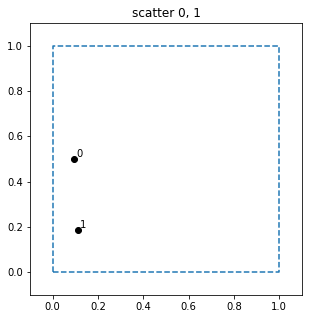

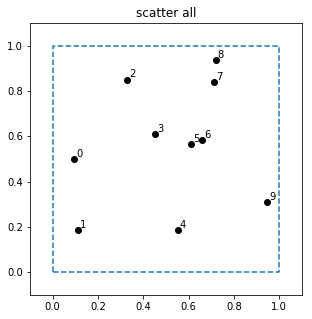

In [11]:
pts.scatter(pts.figure('scatter 0, 1'), [0, 1])
pts.scatter(pts.figure('scatter all'))
show()

### Primitives

Now we can define a few useful operations on vertices.
`isrightof` determines if the point, z, is to the right of the line segment from x to y.
When the points are approximately collinear, z is not right.
Similarly for `isleftof`.

In [12]:
def method(self, px, py, x, y, epsilon=0.0000001):
    """returns 1, 0, -1 if point px, py is right of, collinear, or left of the directed line from point x to point y"""
    b_x, b_y = px - self.x[x], py - self.y[x]
    c_x, c_y = self.x[y] - self.x[x], self.y[y] - self.y[x]

    d = 2 * (b_x * c_y - b_y * c_x) # like circumcircle
    if d > epsilon:
        return 1
    if d < -epsilon:
        return -1

    return 0

pointset.cw = method

In [13]:
pts=pointset(pts=[(0.00, 0.00), (0.50, 0.25), (1.00, .50)])
for py, a in [(0.00, 1), (0.4999999, 1), (0.49999999, 0), (0.50, 0), (1.00, -1)]:
    v = pts.cw(1.0, py, 0, 1)
    print('cw (1.0, {}) relative to 0, 1: {}'.format(py, v))
    if v != a:
        raise AssertionError('cw of {} is not {}'.format(v, a))

cw (1.0, 0.0) relative to 0, 1: 1
cw (1.0, 0.4999999) relative to 0, 1: 1
cw (1.0, 0.49999999) relative to 0, 1: 0
cw (1.0, 0.5) relative to 0, 1: 0
cw (1.0, 1.0) relative to 0, 1: -1


In [14]:
def method(self, px, py, x, y, epsilon=0.0000001):
    """returns True if point px, py is right of the directed line from point x to point y"""
    return True if self.cw(px, py, x, y) == 1 else False

pointset.xyisrightof = method

In [15]:
v = pts.xyisrightof(1, .5, 0, 1)
print('xyisrightof (1, .5) relative to 0, 1: {}'.format(v))
if v != False:
    raise AssertionError('xyisrightof {} is not {}'.format(v, a))

xyisrightof (1, .5) relative to 0, 1: False


In [16]:
def method(self, px, py, x, y, epsilon=0.0000001):
    """returns True if point px, py is left of the directed line from point x to point y"""
    b_x, b_y = px - self.x[x], py - self.y[x]
    c_x, c_y = self.x[y] - self.x[x], self.y[y] - self.y[x]

    d = 2 * (b_x * c_y - b_y * c_x) # like circumcircle
    if d < -epsilon:
        return True
    return False

pointset.xyisleftof = method

In [17]:
v = pts.xyisleftof(1, .5, 0, 1)
print('xyisleftof (1, .5) relative to 0, 1: {}'.format(v))
if v != False:
    raise AssertionError('xyisleftof {} is not {}'.format(v, a))

xyisleftof (1, .5) relative to 0, 1: False


In [18]:
def method(self, z, x, y, epsilon=0.0000001):
    """returns True if point z is right of the directed line from point x to point y"""
    return self.xyisrightof(self.x[z], self.y[z], x, y)

pointset.isrightof = method

In [19]:
v = pts.isrightof(2, 0, 1)
print('isrightof (1, .5) relative to 0, 1: {}'.format(v))
if v != False:
    raise AssertionError('isrightof {} is not {}'.format(v, a))

isrightof (1, .5) relative to 0, 1: False


In [20]:
def method(self, z, x, y, epsilon=0.0000001):
    """returns True if point z is left of the directed line from point x to point y"""
    return self.xyisleftof(self.x[z], self.y[z], x, y)

pointset.isleftof = method

In [21]:
v = pts.isleftof(2, 0, 1)
print('isleftof (1, .5) relative to 0, 1: {}'.format(v))
if v != False:
    raise AssertionError('isleftof {} is not {}'.format(v, a))

isleftof (1, .5) relative to 0, 1: False


In [22]:
print(pts)
for i in [2]:
    print('{} is right, left of 0, 1: {}, {}'.format(i, pts.isrightof(i, 0, 1), pts.isleftof(i, 0, 1)))

[(+0.000, +0.000), (+0.500, +0.250), (+1.000, +0.500)]
2 is right, left of 0, 1: False, False


A Delaunay triangulation has the characteristic that the circumcircle of a triangle in the triangulation does not contain any other point in the pointset.
`circumcircle` determines the center and radius of the unique circumcircle of a triangle.

Perhaps the sign of the denominator should be returned too.
This information could be used to associate a direction of the triangle.

In [23]:
pointset.PINF = float('inf')
pointset.NINF = float('-inf')

def method(self, h, i, j, epsilon=0.0000001):
    """
    Determines the circumcircle of the triangle connecting vertices h, i, j
        
    Based on psuedo code on [Wikipedia](https://en.wikipedia.org/wiki/Circumscribed_circle)
    for cartesian coordinates. The problem is shifted to the origin by offseting i, j by
    the h vertex. Since the circumcircle passes through the origin, its radius is just
    the distance to the circumcenter. After calculating the center (x, y), the result is shift back. 
        
    Parameters
    ----------
    h : int
        a point of the triangle
    i : int
        a point of the triangle
    j : int
        a point of the triangle

    Returns
    -------
    float
        x position of the center of the circumcircle
    float
        y position of the center of the circumcircle
    float
        the radius of the circumcircle
    """
        
    # vectors b, c are i, j relative to h
    b_x, c_x = self.x[i] - self.x[h], self.x[j] - self.x[h]
    b_y, c_y = self.y[i] - self.y[h], self.y[j] - self.y[h]

    # calculate the circle
    d = 2 * ( b_x * c_y - b_y * c_x )
    u_x = ( c_y * (b_x * b_x + b_y * b_y) - b_y * (c_x * c_x + c_y * c_y) ) 
    u_y = ( b_x * (c_x * c_x + c_y * c_y) - c_x * (b_x * b_x + b_y * b_y) )

    if d < -epsilon or d > epsilon:
        u_x = u_x / d
        u_y = u_y / d
        r = (u_x * u_x + u_y * u_y)**0.5
        x = u_x + self.x[h]
        y = u_y + self.y[h]
    else: # collinear points
        if u_x < epsilon and u_x > -epsilon:
            x = 0
        elif (u_x >= 0) == (d >= 0):
            x = pointset.PINF
        else:
            x = pointset.NINF
        if u_y < epsilon and u_y > -epsilon:
            y = 0
        elif (u_y >= 0) == (d >= 0):
            y = pointset.PINF
        else:
            y = pointset.NINF
        r = pointset.PINF

    return x, y, r

pointset.circumcircle = method

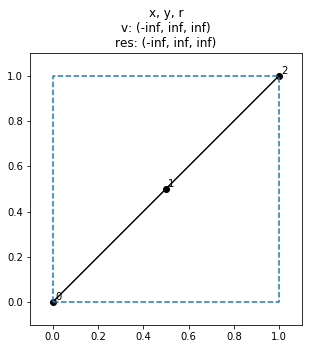

In [24]:
def test(pts, res):
    pts=pointset(pts=pts)
    v = pts.circumcircle(0, 1, 2)
    ax = pts.figure(title='x, y, r\nv: {}\nres: {}'.format(v, res))
    pts.scatter(ax)
    ax.arrow(pts.x[0], pts.y[0], pts.x[2] - pts.x[0], pts.y[2] - pts.y[0],
             length_includes_head=True, head_length=0)
    show()
    if v != res:
        raise AssertionError('v changed: {}'.format(v))
test([(0, 0), (.5, .5), (1, 1)], (pointset.NINF, pointset.PINF, pointset.PINF))

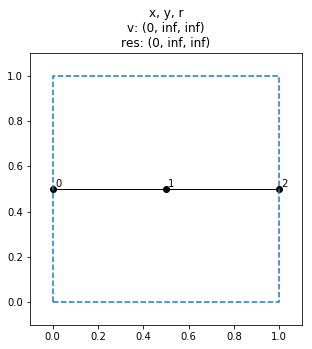

In [25]:
test([(0,.5), (.5,.5), (1,.5)], (0, pointset.PINF, pointset.PINF) )

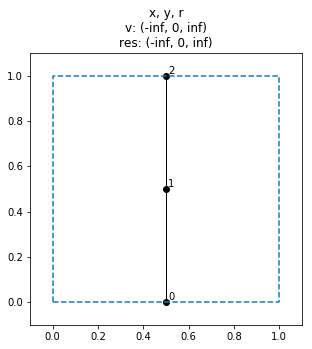

In [26]:
test([(.5, 0), (.5, .5), (.5, 1)], (pointset.NINF, 0, pointset.PINF) )

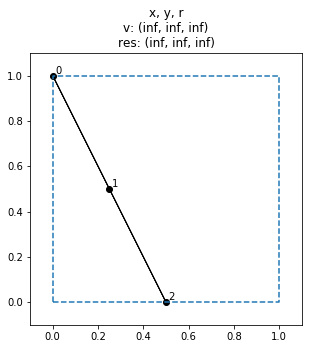

In [27]:
test([(0, 1), (.25, .5), (.5, 0)], (pointset.PINF, pointset.PINF, pointset.PINF) )

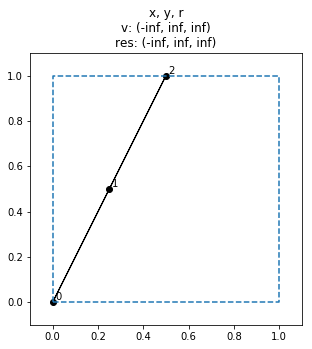

In [28]:
test([(0, 0), (.25, .5), (.5, 1)], (pointset.NINF, pointset.PINF, pointset.PINF) )

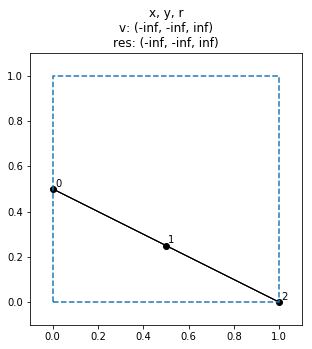

In [29]:
test([(0, 0.499999999999), (.5, .25), (1, 0)], (pointset.NINF, pointset.NINF, pointset.PINF) )

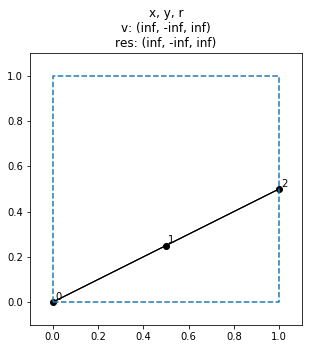

In [30]:
test([(0, 0), (.5, .25), (1, 0.499999999999)], (pointset.PINF, pointset.NINF, pointset.PINF) )

Now we can build a good plotting tool that handles points, directed line segments, and circumcircles of triangles.

In [31]:
def method(self, ax, lines, c='b', shape='left', width=None, length=None):
    """draw arrows"""
    if width == None:
        width = 0.03;
    if length == None:
        length = 0.05
    for line in lines:
        x, y = line[0], line[1]
        ax.arrow(self.x[x], self.y[x], self.x[y] - self.x[x], self.y[y] - self.y[x],
                 fc=c, ec=c,
                 length_includes_head=True, head_width=width, head_length=length, shape=shape)
    return

pointset.arrows = method

In [32]:
def method(self, ax, xyrcircles, c='y', centers=False):
    """draw xyr circles"""
    for circle in xyrcircles:
        x, y, r = circle
        if r != pointset.PINF:
            ax.add_artist(Circle((x, y), r, ec=c, fill=False))
        else:
            ax.arrow(self.x[h], self.y[h], self.x[i] - self.x[h], self.y[i] - self.y[h],
                     fc=c, ec=c, length_includes_head=True, head_length=0)
            ax.arrow(self.x[i], self.y[i], self.x[j] - self.x[i], self.y[j] - self.y[i],
                     fc=c, ec=c, length_includes_head=True, head_length=0)
    cs = [ [x, y] for x, y, r in xyrcircles if r != pointset.PINF ]
    ax.scatter([x[0] for x in cs], [x[1] for x in cs], c='b')
    return

pointset.xyrcircles = method

In [33]:
def method(self, ax, circles, c, centers):
    """draw circles"""
    self.xyrcircles(ax, [self.circumcircle(v[0], v[1], v[2]) for v in circles], c, centers)
    return

pointset.circles = method

In [34]:
def method(self, lines=[], redlines=[],
           circles=[], xyrcircles=[], centers=False,
           vertices=None, title='pointset', adj=False, length=None):
    """plotting tool"""
    if 'plot' not in self.options:
        return
    if vertices == None:
        vertices = [i for i in range(self.npoints)]
    ax = self.figure(title)
    self.scatter(ax, vertices)
    
    if adj:
        for i in vertices:
            for j in self.a[i]:
                self.arrows(ax, [ [i, j] ], length=length)

    self.arrows(ax, lines, length=length)
    self.arrows(ax, redlines, c='r', length=length)
    self.circles(ax, circles, 'r', centers)
    self.xyrcircles(ax, xyrcircles, 'y', centers)
    show()
    return

pointset.plot = method

Here are some examples of point sets.

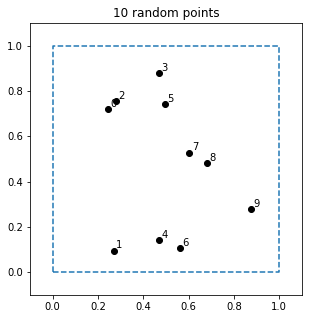

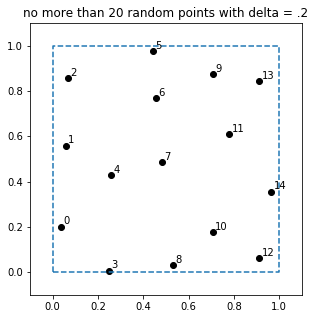

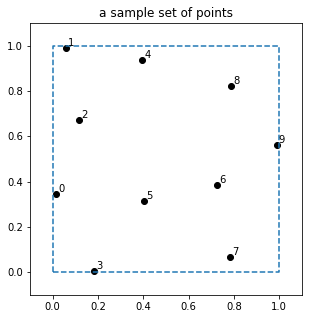

In [35]:
pts = pointset()
pts.options.add('plot')
pts.plot(title='10 random points')

pts = pointset(n=20, delta=.2)
pts.options.add('plot')
pts.plot(title='no more than 20 random points with delta = .2')

pts = pointset(name="rnd10")
pts.options.add('plot')
pts.plot(title='a sample set of points')

Recall that the vertices are sorted by x and y.
The line from the minimum vertex to the maximum vertex therefore splits the points in 2.

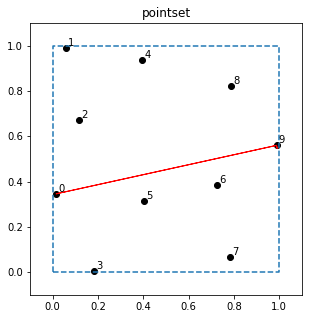

right tests
  0 is not right of line [0, 9]
  1 is not right of line [0, 9]
  2 is not right of line [0, 9]
  3 is right of line [0, 9]
  4 is not right of line [0, 9]
  5 is right of line [0, 9]
  6 is right of line [0, 9]
  7 is right of line [0, 9]
  8 is not right of line [0, 9]
  9 is not right of line [0, 9]
left tests
  0 is not left of line [0, 9]
  1 is left of line [0, 9]
  2 is left of line [0, 9]
  3 is not left of line [0, 9]
  4 is left of line [0, 9]
  5 is not left of line [0, 9]
  6 is not left of line [0, 9]
  7 is not left of line [0, 9]
  8 is left of line [0, 9]
  9 is not left of line [0, 9]


In [36]:
pts.options.add('plot')
pts.plot(redlines=[ [0, pts.npoints-1] ], length=0)
print('right tests')
for i in range(pts.npoints):
    print('  {} {} right of line [0, {}]'.format(i, 'is' if pts.isrightof(i, 0, pts.npoints-1) else 'is not', pts.npoints-1))
print('left tests')
for i in range(pts.npoints):
    print('  {} {} left of line [0, {}]'.format(i, 'is' if pts.isleftof(i, 0, pts.npoints-1) else 'is not', pts.npoints-1))

The Delaunay triangulation algorithm defines a function `qtest` which determines if a point k is outside the circumcircle of a triangle.

In [37]:
def method(self, h, i, j, k):
    """
    returns True if point k is not in the interior of the circumcircle of the triangle h, i, j
    
    The vertices h, i, j are explicitly tested for and defined to be not inside the circumcircle.
    Also k is interior for any set of collinear vertices h, i, j.
    """
    x, y, r = self.circumcircle(h, i, j)
    if k == h or k == i or k == j:
        return True, x, y, r

    if r == pointset.PINF: # special case of collinear points
        fk = pointset.isrightof(k, h, j)
        if x == 0:
            px = 0.5
            py = 1 if y > 0 else 0
        elif y == 0:
            px = 1 if x > 0 else 0
            py = 0.5
        else:
            px = 1 if x > 0 else 0
            py = 1 if y > 0 else 0
        fp = pointset.xyisrightof(px, py, lo, hi)
        flag = fk == fp
        return flag, x, y, r

    dx = self.x[k] - x
    dy = self.y[k] - y
    d = (dx*dx+dy*dy)**0.5
    return True if d >= r else False, x, y, r

pointset.qtest = method

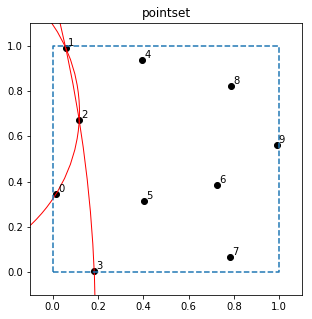

vertex 3 is outside the circumcircle of the vertexes 0, 1, 2
vertex 0 is inside the circumcircle of the vertexes 1, 2, 3


In [38]:
pts.plot(circles = [ [0, 1, 2], [1, 2, 3] ])
print('vertex 3 is {} the circumcircle of the vertexes 0, 1, 2'.format('outside' if pts.qtest(0, 1, 2, 3)[0] else 'inside'))
print('vertex 0 is {} the circumcircle of the vertexes 1, 2, 3'.format('outside' if pts.qtest(1, 2, 3, 0)[0] else 'inside'))

For vertrices that are on the convex hull boundary, the first element in its adjacancy list is always the next counter clockwise vertex.

In [39]:
def method(self, n, adj=None):
    """Given a point, n, on the convex hull boundary, return the next ccw point"""
    if adj == None:
        adj = self.a
    return adj[n][0]

pointset.first = method

`boundary` returns the vertices on the convex hull boundary.
Note that the left most point (and the right most point) are always on the convex hull boundary.
I've added a little flexibility here that *may* allow interior starting points to find their boundary.
Suppose n in not on the boundary, then `first` is not well defined.
But if the adjacancy list for interior point always starts with the left most vertex,
then `v` will contain the left path to the boundary and then the boundary itself.
Suppose `m` is the first vertex on the boundary.
Then by cutting out the vertices before `m`, we are left with only the boundary.

In [40]:
def method(self, n, adj=None):
    """Given a point, n, return the convex hull boundary assuming n is on the boundary"""
    if adj == None:
        adj = self.a
    v = [n]
    while True:
        n = self.first(n, adj)
        try:
            i = v.index(n)
            break
        except:
            v.append(n)
    return v[i:]

pointset.boundary = method

In [41]:
def method(self, n, adj=None):
    """Given a point, n, return the convex hull boundary edges assuming n is on the boundary"""
    if adj == None:
        adj = self.a
    b = self.boundary(n, adj)
    e = [ ]
    for v in range(len(b)):
        e.append([b[v-1], b[v]])
    return e

pointset.boundaryedges = method

In [42]:
def method(self, v):
    """returns a reasonable string representation of the convex hull"""
    left = min(v)
    right = max(v)
    nv = len(v)
    sl = ' left: {}'.format(left)
    sr = ' right: {}'.format(right)
    if nv > 5:
        s = ', '.join(str(v[i]) for i in range(0, 3)) + ', ..., ' + ', '.join(str(v[i]) for i in range(nv-3, nv))
    else:
        s = ', '.join(str(v[i]) for i in range(0, nv))
    return '<chb{}{} <{}>>'.format(sl, sr, s)

pointset.chb = method

In [43]:
def method(self, n, title):
    """plot the convex hull boundary"""
    v = self.boundary(n)
    self.plot(title='{}\n{}'.format(title, self.chb(v)),
              vertices=v,
              lines=[ [i, self.first(i)] for i in v]
             )
    return

pointset.chbplot = method

`append` is a helper method for `tripart2` and `tripart3` - the non-recursive triangulations of 2 and 3 points.

In [44]:
def method(self, vertex, neighbor):
    """Appends a neighbor to a vertex array"""
    self.a[vertex].append(neighbor)
    return

pointset.append = method

The triangulation algorithm recursively defined.
I start be handling the non-recursive parts.

The triangulation of 1 point is not interesting - a single point has no neighbors.
`tripart2` sets up the adjacancies for a 2 point triangulation.

In [45]:
def method(self, vertexes):
    """Update adjacancy for 2 points, returns leftmost vertex"""
    left = 0 if vertexes[0] < vertexes[1] else 1
    for v, n in [ [vertexes[0], vertexes[1]], [vertexes[1], vertexes[0]] ]:
        self.a[v].append(n)
    if 'ch' in self.options:
        self.chbplot(vertexes[0], title="ch 2 points")
    return vertexes[left]

pointset.tripart2 = method

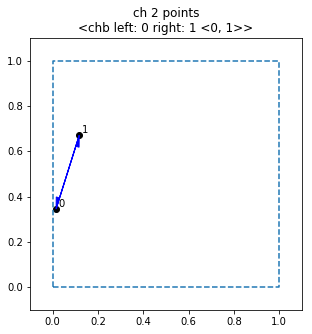

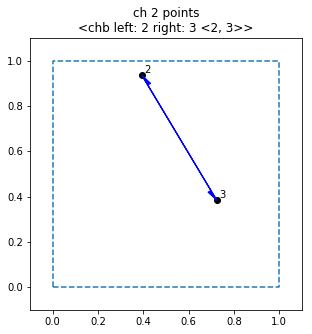

2

In [46]:
pts = pointset(name="rnd4")
for o in ['log', 'plot', 'ch']: pts.options.add(o)
pts.tripart2([0, 1])
pts.tripart2([2, 3])

`tripart3` handles the 3 point triangulation.
The adjacancies are carefully set up in a counter clockwise direction.

In [47]:
def method(self, vertexes):
    """Update adjacancy and return chb for 3 points, returns leftmost vertex"""
    v = sorted(vertexes)
    left = 0
    if self.isrightof(v[0], v[1], v[2]):
        v = [v[0], v[2], v[1]]
        right = 1
    else: # this includes the collinear case
        v = [v[0], v[1], v[2]]
        right = 2
    vs = [ [v[-1], v[0]], [v[0], v[1]], [v[1], v[2]] ]
    for p0, p1 in vs:
        self.a[p0].append(p1)
    for p0, p1 in vs:
        self.a[p1].append(p0)

    if 'ch' in self.options:
        self.chbplot(vertexes[0], title="ch 3 points")
    return v[left]

pointset.tripart3 = method

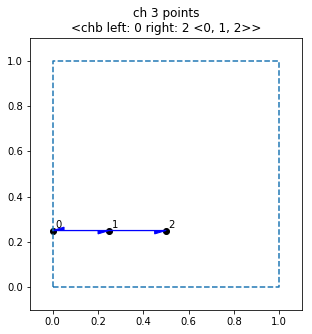

In [48]:
pts = pointset(name="hline3")
for o in ['log', 'plot', 'ch']: pts.options.add(o)
pts.tripart3([0, 1, 2])
if pts.boundary(0) != [0, 1, 2]:
    raise AssertionError('boundary changed: {}'.format(pts.boundary(0)))

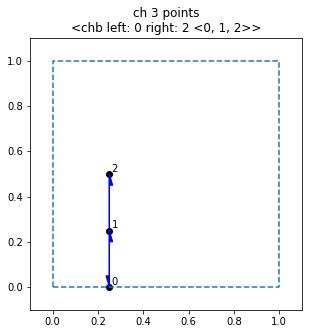

In [49]:
pts = pointset(name="vline3")
for o in ['log', 'plot', 'ch']: pts.options.add(o)
pts.tripart3([0, 1, 2])
if pts.boundary(0) != [0, 1, 2]:
    raise AssertionError('boundary changed: {}'.format(pts.boundary(0)))

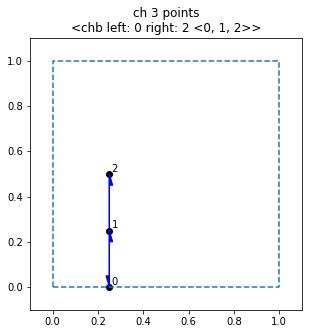

In [50]:
pts = pointset(name="vline3")
for o in ['log', 'plot', 'ch']: pts.options.add(o)
pts.tripart3([0, 1, 2])
if pts.boundary(0) != [0, 1, 2]:
    raise AssertionError('boundary changed: {}'.format(pts.boundary(0)))

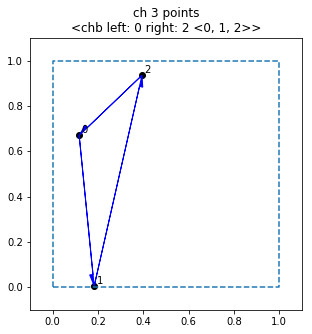

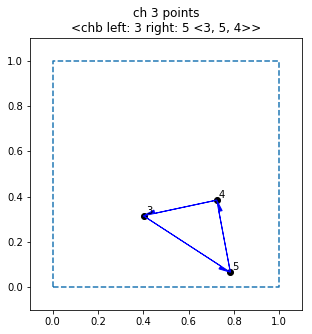

3

In [51]:
pts = pointset(name="rnd6")
for o in ['log', 'plot', 'ch']: pts.options.add(o)
pts.tripart3([0, 1, 2])
pts.tripart3([3, 4, 5])

In [52]:
print('adjacancy: ' + '  '.join(['{}:{}'.format(i, pts.a[i]) for i in range(pts.npoints)]))

adjacancy: 0:[1, 2]  1:[2, 0]  2:[0, 1]  3:[5, 4]  4:[3, 5]  5:[4, 3]


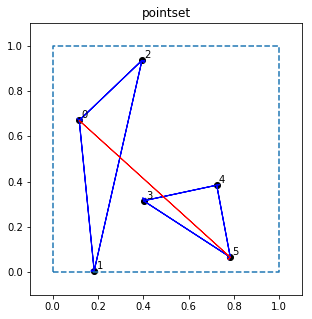

In [53]:
pts.plot(adj=True, redlines=[ [0, -1] ], length=0)

In [54]:
def method(self, x, y):
    """Find the clockwise vertex of y in x"""
    a = self.a[x]
    i = a.index(y)
    return a[i-1]

pointset.pred = method

In [55]:
 # should be 4
if pts.pred(3, 5) != 4:
    AssertionError('unexpected value: {}'.format(pts.pred(3, 5)))

In [56]:
def method(self, x, y):
    """Find the counter clockwise vertex of y in x"""
    a = self.a[x]
    i = a.index(y) + 1
    if i == len(a):
        i = 0
    return a[i]

pointset.succ = method

In [57]:
pts.succ(0, 1) # should be 2

2

### Convex Hull

The recursive triangulation algorithm merges a left and right triangluation by finding the upper and lower common tangents between them. These common tangents can be determined solely from the left and right convex hulls.

To visualize the process, a specialized plot is needed.

In [58]:
def method(self, title, label, flag, z, x, y):
    """Convex Hull Common Tangent plot"""
    if 'plot' not in self.options:
        return
    lv = self.boundary(x)
    rv = self.boundary(y)
    ax = self.figure('{}: {} right\nz{}: {} x: {} y:{}\nl: {}\nr:{}'
                     .format(title,
                            'is' if flag else 'not',
                            label, z, x, y,
                            self.chb(lv),
                            self.chb(rv)))
    self.scatter(ax, lv, 'r')
    self.scatter(ax, rv, 'g')
    self.scatter(ax, [z], c='k')
    self.arrows(ax, [ [x, y] ])
    show()
    return
pointset.chctplot = method

Here is a sample calculation for the preliminary step in the lower common tangent algorithm.
x is the right most point in the left triangulation.
y is the left most point in the right triangulation.
zl is the first clockwise point on the left relative to x.
zr is the first counter clockwise point on the right relative to y.

In the plot the left triangulation points are red and the right ones are green.
The point under consideration is black.
The title has a representation of the convex hull boundary.

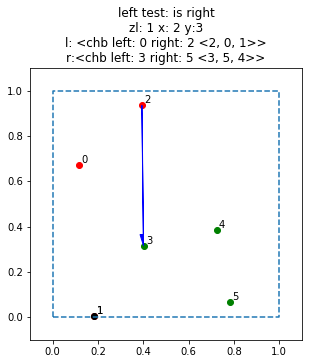

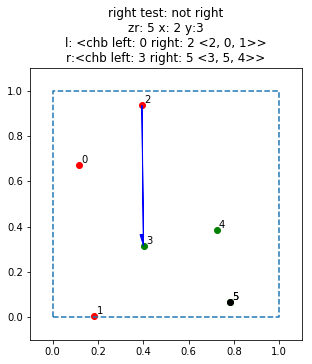

In [59]:
x, y = max(pts.boundary(0)), min(pts.boundary(3))
zl, zr = pts.first(x), pts.first(y)
zl = pts.pred(x, zl)
pts.chctplot('left test', 'l', pts.isrightof(zl, x, y), zl, x, y)
pts.chctplot('right test', 'r', pts.isrightof(zr, x, y), zr, x, y)

In [60]:
def method(self, l, r):
    """
    Determines the lower common tangent, LCT, of a pair of left and right convex hulls.
        
    This iterative algorithm starts with the rightmost vertex in the left ch, x, and the
    leftmost vertex, y, in the right ch. The next pair of points to be considered are:
    the next clockwise vertex on the left side, zl, and the next counter clockwise vertex
    on the right side, zr. If the right candidate, zr, is right of the line from x to y,
    then advance the right side vertices. If not, test if the left candidate, zl, is right
    of the line from x to y. If it is, then advance the left side vertices. If not, then
    x, y are the vertices of the LCT and no points are on the right side of this line.

    Parameters
    ----------
    l : vertex
        a left convex hull vertex
    r : vertex
        a right convex hull vertex

    Returns
    -------
    int
        index to the left convex hull vertex of the LCT.
    int
        index to the right convex hull vertex of the LCT.
    """

    lv = self.boundary(l)
    rv = self.boundary(r)
        
    x, y = max(lv), min(rv) # rightmost of left, leftmost of right
    zl, zr = self.first(x), self.first(y) # first ccw vertex
    zl = self.pred(x, zl) # first cw
    
    while True:
        flag = self.isrightof(zr, x, y)
        if 'lct 1' in self.options:
            self.chctplot('lct 1', 'r', flag, zr, x, y)
        if flag:
            zr, y = self.succ(zr, y), zr
        else:
            flag = self.isrightof(zl, x, y)
            if 'lct 2' in self.options:
                self.chctplot('lct 2', 'l', flag, zl, x, y)
            if flag:
                zl, x = self.pred(zl, x), zl
            else:
                break
    return x, y

pointset.chlct = method

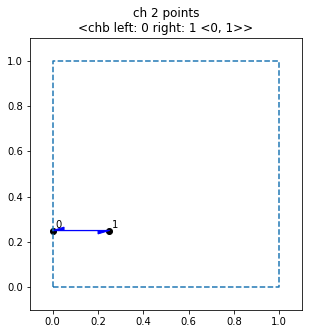

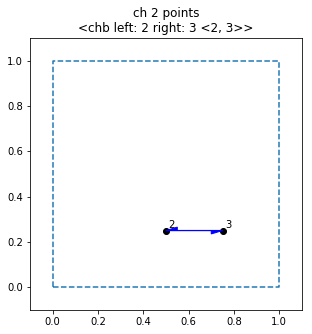

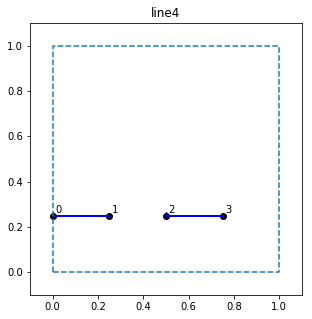

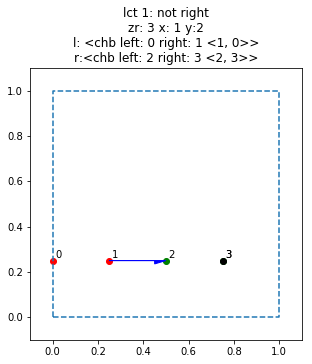

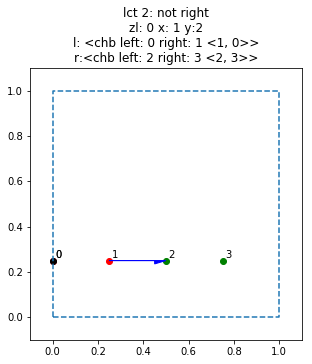

(1, 2)

In [61]:
col = pointset(name='hline4')
for o in ['plot', 'log', 'uct 1', 'uct 2', 'lct 1', 'lct 2', 'ch']: col.options.add(o)
col.tripart2([0, 1])
col.tripart2([2, 3])
col.plot(title='line4', adj=True, length=0)
col.chlct(0,2)

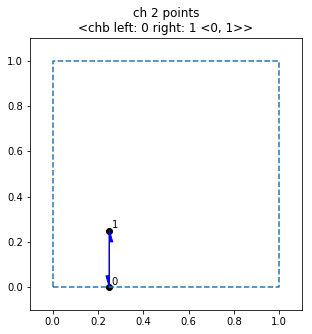

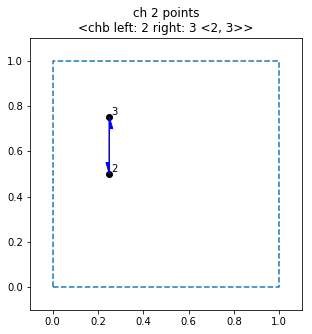

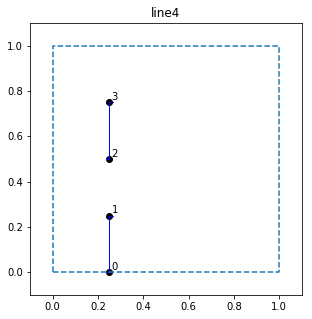

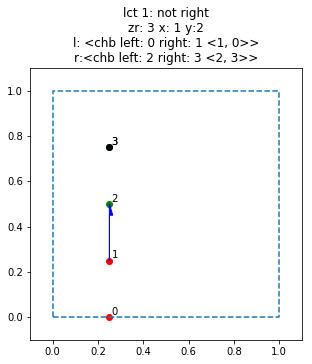

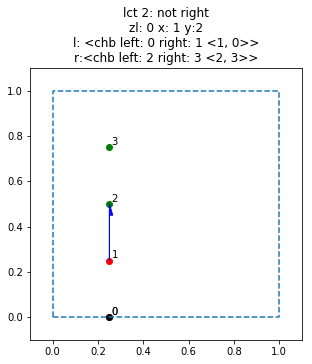

(1, 2)

In [62]:
col = pointset(name='vline4')
for o in ['plot', 'log', 'uct 1', 'uct 2', 'lct 1', 'lct 2', 'ch']: col.options.add(o)
col.tripart2([0, 1])
col.tripart2([2, 3])
col.plot(title='line4', adj=True, length=0)
col.chlct(0,2)

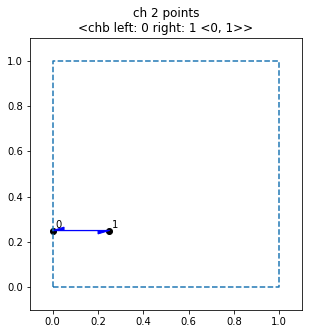

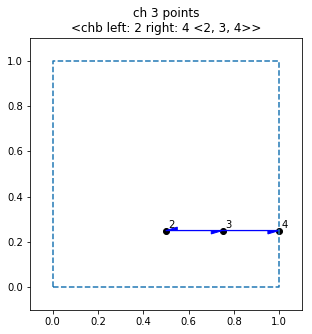

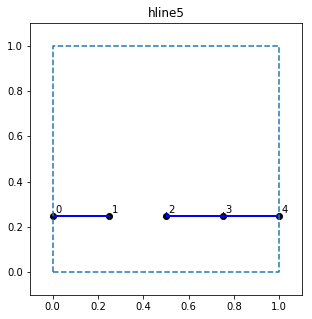

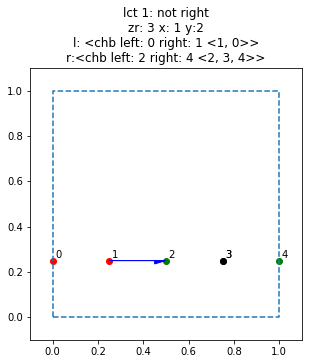

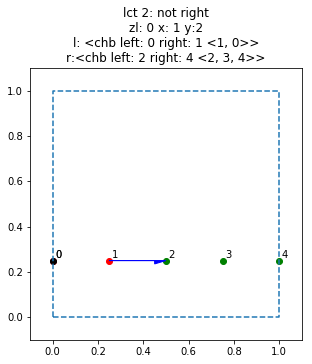

(1, 2)

In [63]:
col = pointset(name='hline5')
for o in ['plot', 'log', 'uct 1', 'uct 2', 'lct 1', 'lct 2', 'ch']: col.options.add(o)
col.tripart2([0, 1])
col.tripart3([2, 3, 4])
col.plot(title='hline5', adj=True, length=0)
col.chlct(0,2)

In [64]:
def method(self, l, r):
    """
    Determines the upper common tangent, UCT, of a pair of left and right convex hulls.
        
    This iterative algorithm starts with the rightmost vertex in the left ch, x, and the
    leftmost vertex, y, in the right ch. The next pair of points to be considered are:
    the next counter clockwise vertex on the left side, zl, and the next clockwise vertex
    on the right side, zr. If the right candidate, zr, is not right of the line from x to y,
    then advance the right side vertices. If so, test if the left candidate, zl, is right
    of the line from x to y. If not, then advance the left side vertices. If so, then
    x, y are the vertices of the UCT and all points are on the right side of this line.

    Parameters
    ----------
    l : vertex
        a left convex hull vertex
    r : vertex
        a right convex hull vertex

    Returns
    -------
    int
        index to the left convex hull vertex of the UCT.
    int
        index to the right convex hull vertex of the UCT.
    """

    lv = self.boundary(l)
    rv = self.boundary(r)
        
    x, y = max(lv), min(rv) # rightmost of left, leftmost of right
    zl, zr = self.first(x), self.first(y) # first ccw vertex
    zr = self.pred(y, zr) # first cw

    while True:
        flag = not self.isleftof(zr, x, y)
        if 'uct 1' in self.options:
            self.chctplot('uct 1', 'r', flag, zr, x, y)
        if flag:
            flag = not self.isleftof(zl, x, y)
            if 'uct 2' in self.options:
                self.chctplot('uct 2', 'l', flag, zl, x, y)
            if flag:
                break
            else:
                zl, x = self.succ(zl, x), zl
        else:
            zr, y = self.pred(zr, y), zr
    return x, y

pointset.chuct = method

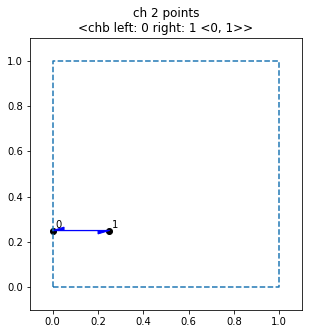

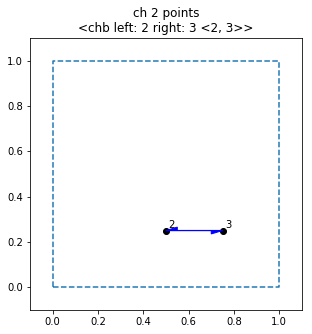

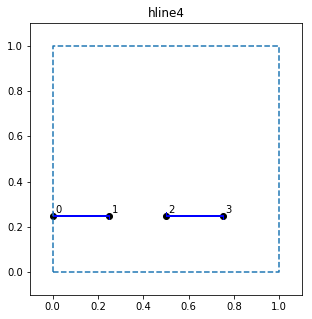

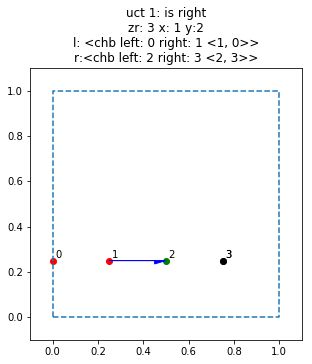

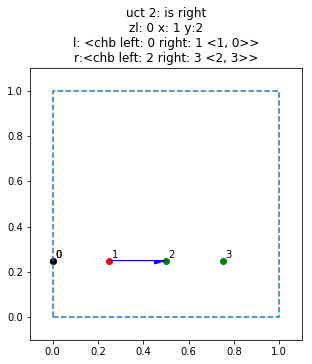

(1, 2)

In [65]:
col = pointset(name='hline4')
for o in ['plot', 'log', 'uct 1', 'uct 2', 'lct 1', 'lct 2', 'ch']: col.options.add(o)
col.tripart2([0, 1])
col.tripart2([2, 3])
col.plot(title='hline4', adj=True, length=0)
col.chuct(0,2)

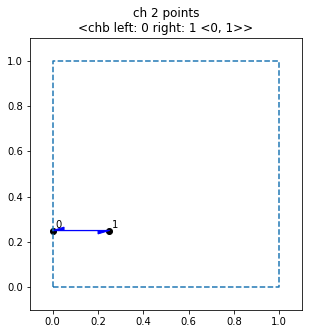

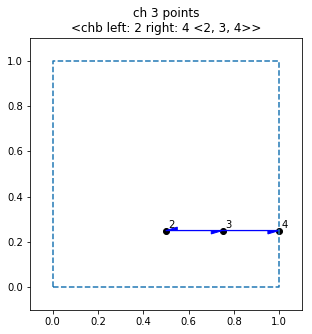

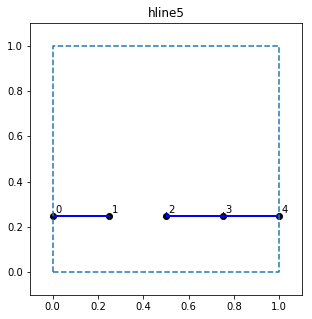

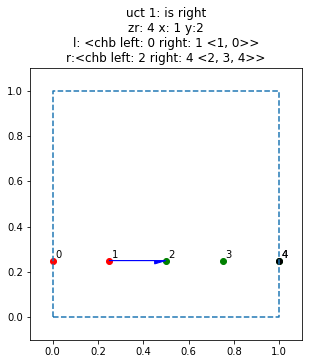

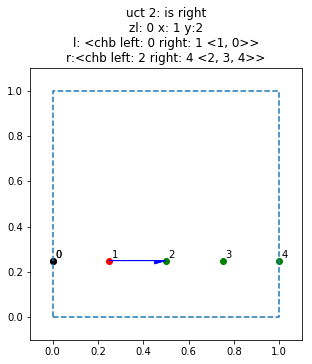

(1, 2)

In [66]:
col = pointset(name='hline5')
for o in ['plot', 'log', 'uct 1', 'uct 2', 'lct 1', 'lct 2', 'ch']: col.options.add(o)
col.tripart2([0, 1])
col.tripart3([2, 3, 4])
col.plot(title='hline5', adj=True, length=0)
col.chuct(0,2)

### Triangulation

The core method of the triangulation, `merge`, can now be defined. This method combines a left and right triangulation using the upper and lower common tangents.

Bur first, we define `insert` which is a subtle method that maintains the adjacancy lists.
The l and r vertices are inserted into each other's lists.

**Recall that this method cannot properly update collinear triangles,
since the middle point cannot have 2 distinct ccw neighbors**

In [67]:
def method(self, l, r):
    """
    Update l, r adjacancy at appropriate positions.
    
    There are two features to the lists:
        1.  If a vertex is on the convex hull boundary, then the first element
            on the list must be the counter clockwise neighbor on the boundary.
        2.  The list is ordered in a counter clockwise direction.
    
    insert0 traverses the list. Each element is compared to the x, y line segment.
    Search for the first vertex on the other side of the line.
    Handle all the cases:
        all on one side, moving ccw: append
        all on one side, moving cw: prepend
        moving ccw: insert before change
        moving cw: insert after change
    """

    if 'log insert' in self.options:
        def log(str):
            self.log(str)
            return
    else:
        def log(str):
            return
    
    def isrightof(n, x, y):
        return not self.isleftof(n, x, y)

    def insert0(x, y):
        log('insert {} into {} adj: '.format(y, x) + str(self.a))
        
        a = self.a[x]
        log('{} adj is: '.format(x) + str(a))
        na = len(a)
    
        n = a[0]
        f = isrightof(n, x, y) # true -> ccw, false -> cw
        t = f
        nxt = self.succ if f else self.pred
        log('{}: f is {} rightp: {}, moving {}clockwise'.format(0, n, f, 'counter' if f else ''))
        for i in range(1, na):
            n = nxt(x, n)
            t = isrightof(n, x, y)
            log('{}: n is {} rightp: {}'.format(i, n, t))
            if t != f:
                log('change of side')
                break
        if f == t: # all on one side
            log('all points on one side')
            if f:
                log('append')
                i = na
            else:
                log('prepend')
                i = 0
        elif f:
            i = a.index(n)
            log('ccw, insert before index {}'.format(i))
        else:
            i = a.index(n) + 1
            if i == na:
                i = 0
            log('cw, insert before index {}'.format(i))

        a.insert(i, y)
        log('final a: ' + str(self.a))
        return

    insert0(l, r)
    insert0(r, l)
    return

pointset.insert = method

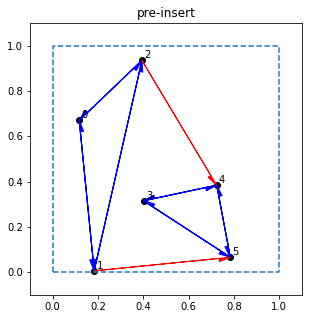

insert 5 into 1 adj: [[1, 2], [2, 0], [0, 1], [5, 4], [3, 5], [4, 3]]
1 adj is: [2, 0]
0: f is 2 rightp: False, moving clockwise
1: n is 0 rightp: False
all points on one side
prepend
final a: [[1, 2], [5, 2, 0], [0, 1], [5, 4], [3, 5], [4, 3]]
insert 1 into 5 adj: [[1, 2], [5, 2, 0], [0, 1], [5, 4], [3, 5], [4, 3]]
5 adj is: [4, 3]
0: f is 4 rightp: True, moving counterclockwise
1: n is 3 rightp: True
all points on one side
append
final a: [[1, 2], [5, 2, 0], [0, 1], [5, 4], [3, 5], [4, 3, 1]]


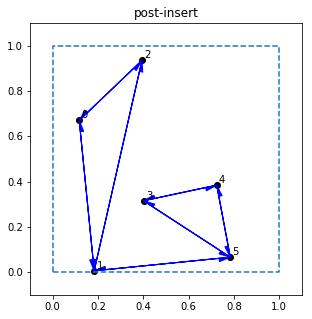

In [68]:
pts=pointset(name='rnd6')
pts.tripart3([0, 1, 2])
pts.tripart3([3, 4, 5])
uct = pts.chuct(0, 3)
lct = pts.chlct(0, 3)
for o in ['plot', 'log', 'log insert', 'uct 1', 'uct 2', 'lct 1', 'lct 2', 'ch']: pts.options.add(o)
pts.plot(title='pre-insert', adj=True, redlines=[ [lct[0], lct[1]], [uct[0], uct[1]] ])
pts.insert(lct[0], lct[1])
pts.plot(title='post-insert', adj=True)

In [69]:
def method(self, l, r):
    """Delete l, r adjacancy"""
    a = self.a[l]
    i = a.index(r)
    del a[i]

    a = self.a[r]
    i = a.index(l)
    del a[i]
    return

pointset.delete = method

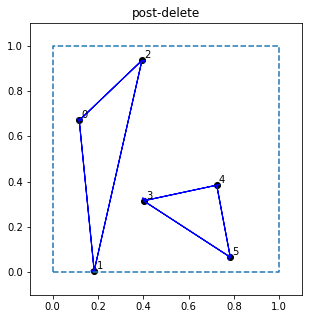

In [70]:
pts.delete(lct[0], lct[1])
pts.plot(title='post-delete', adj=True, length=0)

Merging left and right triangulations is the core of the algorithm.
`mergeplot` displays appropriate information at each decision point.

The active line's end points are in red.
The vertex being considered is in black.

In [71]:
def method(self, d={}):
    if 'plot' not in self.options:
        return
    title = ['dt merge']
    cm = {'c': 'y', 'l': 'r', 'r': 'r', 'r1': 'k', 'r2': 'k', 'l1': 'k', 'l2': 'k'}
    for k in ['c', 'l', 'r', 'r1', 'r2', 'l1', 'l2']:
        if k in d:
            title.append(' {}: {}'.format(k, d[k]))
    ax = self.figure(' '.join(title))
    self.scatter(ax, [i for i in range(self.npoints)], c='b')

    for k in ['l', 'r', 'r1', 'r2', 'l1', 'l2']:
        if k in d:
            self.scatter(ax, [ d[k] ], c=cm[k])

    for k in ['c']:
        if k in d:
            self.circles(ax, [ d[k] ],  c=cm[k], centers=False)

    for i in range(self.npoints):
        for j in self.a[i]:
            if 'hl' in d:
                self.arrows(ax, [ [i, j] ], length=d['hl'])
            else:
                self.arrows(ax, [ [i, j] ])

    show()
    return

pointset.mergeplot = method

`merge` is the core the algorithm. Given a left and right triangluation it combines them
into a single triangulation.

In [72]:
def method(self, uct, lct):
    """Merge triangulations using uct, lct"""

    if 'log' in self.options:
        def log(str):
            self.log(str)
            return
    else:
        def log(str):
            return

    if 'dt_lr' in self.options:
        def mergeplot(d):
            self.mergeplot(d)
            return
    else:
        def mergeplot(d):
            return

    uct_l, uct_r = uct
    l, r = lct

    lv = self.boundary(uct_l)
    rv = self.boundary(uct_r)

    while True:
        log('loop top: l: {}, r: {}'.format(l, r))
        log('init a: ' + str(self.a))
        self.insert(l, r)
        log('updated a: ' + str(self.a))
        mergeplot({'l': l, 'r': r})

        if l == uct_l and r == uct_r:
            break

        a = False
        r1 = self.pred(r, l)
        mergeplot({'l': l, 'r': r, 'r1': r1})
        
        flag = self.isleftof(r1, l, r)
        if flag:
            log('{} is left of {} {}'.format(r1, l, r))
            r2 = self.pred(r, r1)
            while True:
                mergeplot({'c': [r1, l, r], 'r2': r2})
                flag, x, y, radius = self.qtest(r1, l, r, r2)
                if flag:
                    log('{} outside circle'.format(r2))
                    break
                log('{} inside circle, delete {} {}'.format(r2, r, r1))
                log('pre-delete a:' + str(self.a))
                t = self.pred(r, r1)
                self.delete(r, r1)
                log('post-delete a:' + str(self.a))
                r1, r2 = r2, t
        else:
            log('{} is right of {} {}'.format(r1, l, r))
            a = True

        b = False
        l1 = self.succ(l, r)
        mergeplot({'l': l, 'r': r, 'l1': l1})

        flag = self.isrightof(l1 , r, l)
        if flag:
            log('{} is right of {} {}'.format(l1, r, l))
            l2 = self.succ(l, l1)
            while True:
                mergeplot({'c': [l1, l, r], 'l2': l2})
                flag, x, y, radius = self.qtest(l, r, l1, l2)
                if flag:
                    log('{} outside circle'.format(l2))
                    break
                log('{} inside circle, delete {} {}'.format(l2, l, l1))
                log('pre-delete a:' + str(self.a))
                t = self.succ(l, l1)
                self.delete(l, l1)
                log('post-delete a:' + str(self.a))
                l1, l2 = l2, t
        else:
            log('{} is left of {} {}'.format(l1, l, r))
            b = True
        
        if a:
            log('move from left {} to {}'.format(l, l1))
            l = l1
        else:
            if b:
                log('move from right {} to {}'.format(r, r1))
                r = r1
            else:
                mergeplot({'c': [r1, l, r], 'l1': l1})
                flag, x, y, radius = self.qtest(l, r, r1, l1)
                if flag:
                    log('{} outside circle'.format(l1))
                    r = r1
                else:
                    log('{} inside circle'.format(l1))
                    l = l1

    if 'dt_lr merge' in self.options:
        self.mergeplot({'hl': 0.0})

    return

pointset.merge = method

Below is the failure case for 2 collinear triangles.
Note the the final convex hull boundary is [0, 1], instead of [0, 1, 2, 3, 4].
This is due to the limitation that the ccw neighbor of 2 is 3 and cannot also be 1.

loop top: l: 1, r: 2
init a: [[1], [0], [3], [2]]
insert 2 into 1 adj: [[1], [0], [3], [2]]
1 adj is: [0]
0: f is 0 rightp: True, moving counterclockwise
all points on one side
append
final a: [[1], [0, 2], [3], [2]]
insert 1 into 2 adj: [[1], [0, 2], [3], [2]]
2 adj is: [3]
0: f is 3 rightp: True, moving counterclockwise
all points on one side
append
final a: [[1], [0, 2], [3, 1], [2]]
updated a: [[1], [0, 2], [3, 1], [2]]


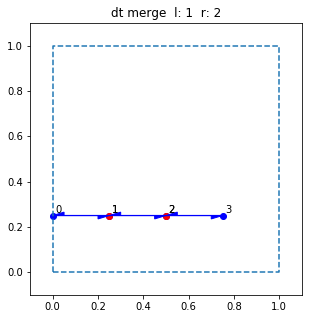

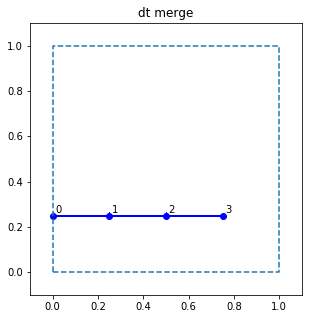

[0, 1]


In [73]:
pts = pointset(name='hline4')
pts.tripart2([0, 1])
pts.tripart2([2, 3])
uct = pts.chuct(0,2)
lct = pts.chlct(0,2)
for o in ['plot', 'log', 'uct 1', 'uct 2', 'lct 1', 'lct 2', 'dt_lr merge', 'dt_lr', 'log insert']: pts.options.add(o)
pts.merge(uct, lct)
print(pts.boundary(0))

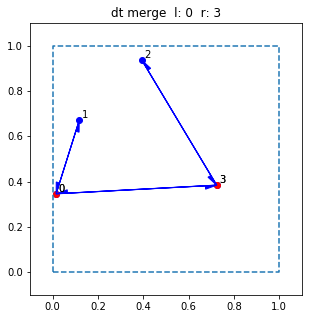

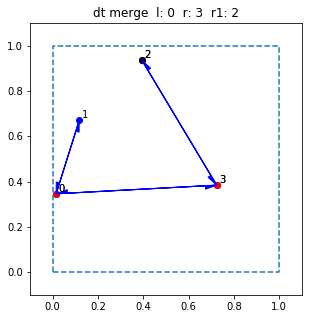

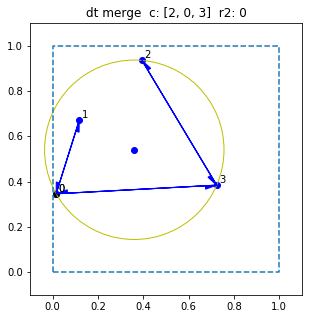

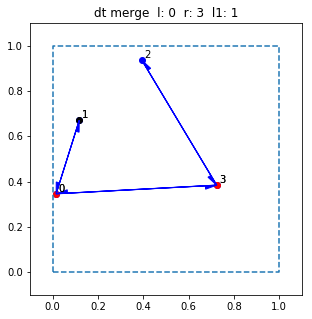

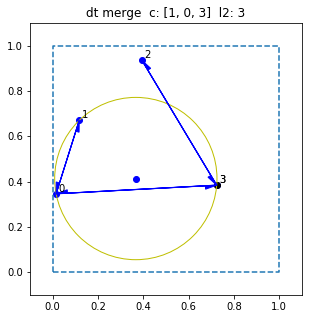

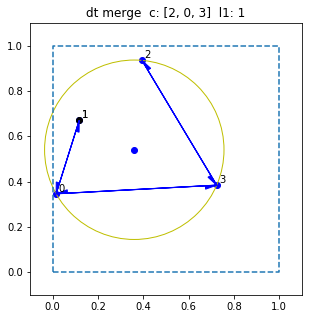

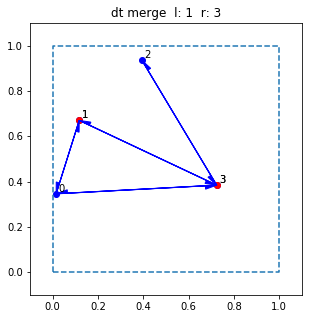

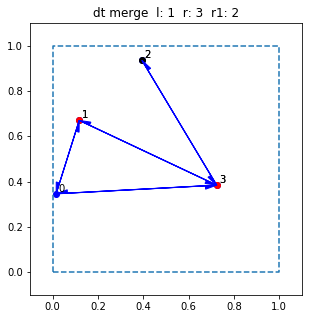

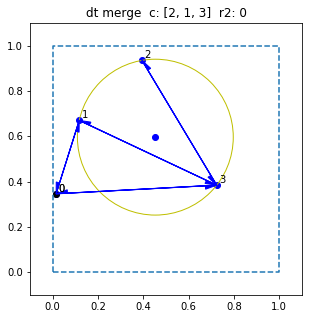

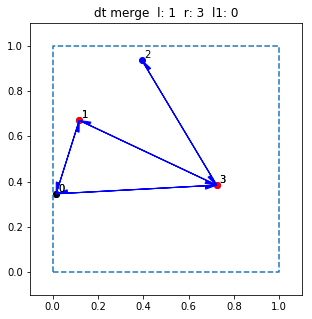

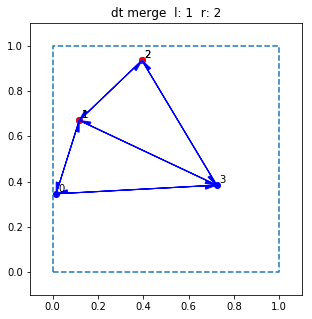

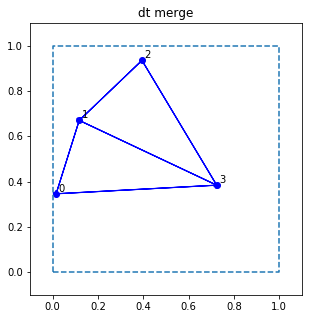

In [74]:
pts = pointset(name='rnd4')
pts.tripart2([0, 1])
pts.tripart2([2, 3])
uct = pts.chuct(0,2)
lct = pts.chlct(0,2)
for o in ['plot', 'dt_lr merge', 'dt_lr']: pts.options.add(o)
pts.merge(uct, lct)

With these methods, we are ready to define the recursive part of the triangulation.
Note that `tripartn` and `tripart` are mutually recursive and `tripart2` and `tripart3` are not recursive.

In [75]:
def method(self, vertexes):
    """Update adjacancy for n > 3 points."""
    nv = len(vertexes)
    nv2 = int(nv/2)
    l = self.tripart([vertexes[i] for i in range(0, nv2)])
    r = self.tripart([vertexes[i] for i in range(nv2, nv)])

    uct = self.chuct(l, r)
    lct = self.chlct(l, r)

    self.merge(uct, lct)

    return l

pointset.tripartn = method

In [76]:
def method(self, vertexes):
    """Recursive entry point for triangulation"""
    nv = len(vertexes)
    if nv == 2:
        return self.tripart2(vertexes)
    if nv == 3:
        return self.tripart3(vertexes)
    return self.tripartn(vertexes)

pointset.tripart = method

Finally we can define the top level entry point.

In [77]:
def method(self):
    self.ha = [ self.a ]
    np = self.npoints
    while np > 5:
        self.a = [[] for _ in range(self.npoints)]
        select = sorted([ [random() if i > 0 else 0, i] for i in range(np)])
        np = int(np / 2 + .5)
        select = sorted([select[i][1] for i in range(np)])
        ch = self.tripart(select)
        self.ha.append(self.a)
    self.a = self.ha[0]
    return

pointset.setheirarchy = method

In [78]:
pts=pointset(name='rnd10')
pts.options.add('plot')
pts.tripart([i for i in range(pts.npoints)])
pts.setheirarchy()
pts.ha[1]

[[3, 7, 8, 1], [0, 8], [], [7, 0], [], [], [], [8, 0, 3], [1, 0, 7], []]

In [79]:
def method(self):
    if self.npoints < 2:
        raise ValueError('Too few points: {}'.format(self.points))
    ch = self.tripart([i for i in range(self.npoints)])
    self.setheirarchy()
    return

pointset.triangulate = method

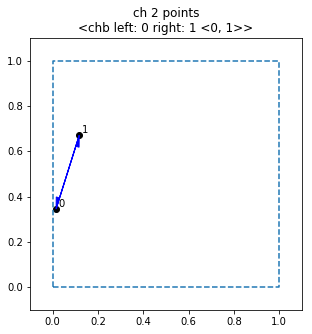

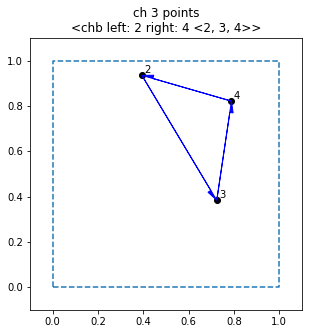

loop top: l: 0, r: 3
init a: [[1], [0], [3, 4], [4, 2], [2, 3]]
updated a: [[3, 1], [0], [3, 4], [4, 2, 0], [2, 3]]


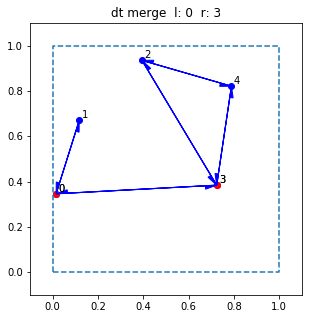

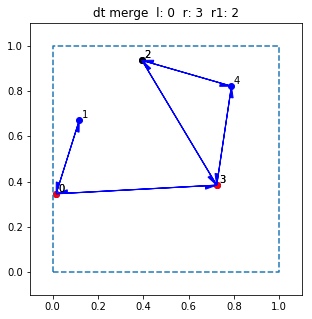

2 is left of 0 3


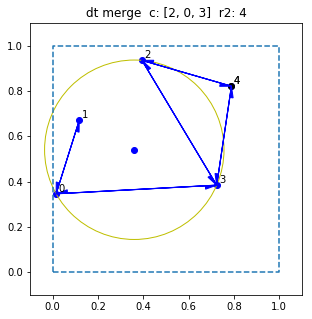

4 outside circle


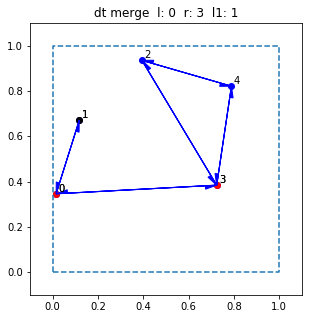

1 is right of 3 0


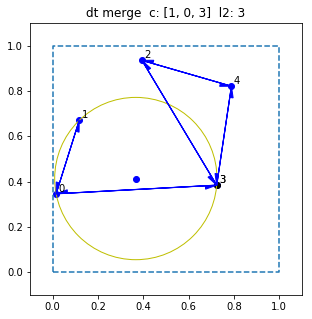

3 outside circle


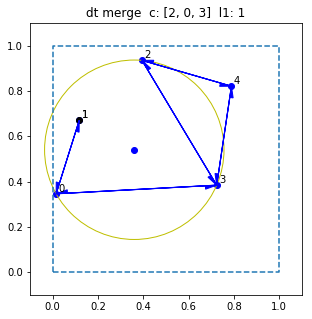

1 inside circle
loop top: l: 1, r: 3
init a: [[3, 1], [0], [3, 4], [4, 2, 0], [2, 3]]
updated a: [[3, 1], [0, 3], [3, 4], [4, 2, 1, 0], [2, 3]]


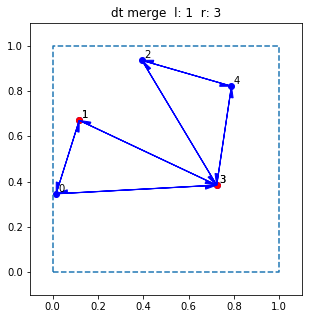

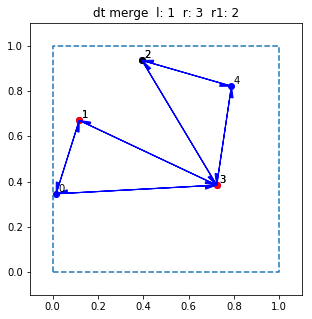

2 is left of 1 3


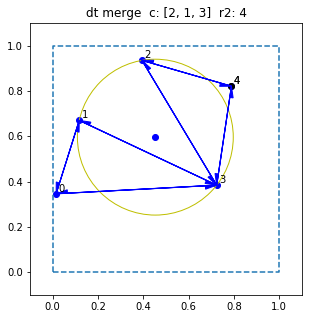

4 outside circle


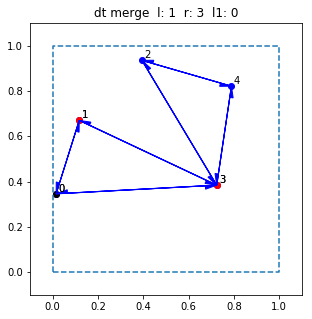

0 is left of 1 3
move from right 3 to 2
loop top: l: 1, r: 2
init a: [[3, 1], [0, 3], [3, 4], [4, 2, 1, 0], [2, 3]]
updated a: [[3, 1], [0, 3, 2], [1, 3, 4], [4, 2, 1, 0], [2, 3]]


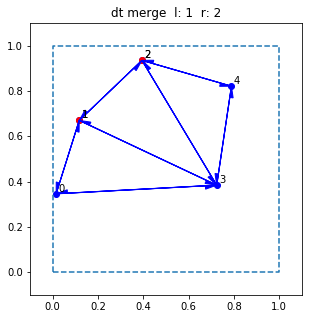

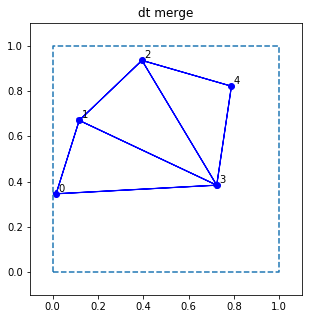

In [80]:
pts = pointset(name="rnd5")
for o in ['log', 'plot', 'ch', 'ch merge', 'dt_lr', 'dt_lr merge']: pts.options.add(o)
pts.triangulate()

Once the triangulation is completed we can find the convex hull boundary.

In [81]:
def method(self, adj=None):
    if adj == None:
        adj = self.a
    return self.boundary(0, adj)

pointset.convexhullvertices = method

In [82]:
pts.convexhullvertices()

[0, 3, 4, 2, 1]

In [83]:
def method(self):
    chv = self.convexhullvertices()
    chv.append(chv[0])
    return [ [chv[i-1], chv[i] ] for i in range(1, len(chv))]

pointset.convexhulllines = method

In [84]:
pts.convexhulllines()

[[0, 3], [3, 4], [4, 2], [2, 1], [1, 0]]

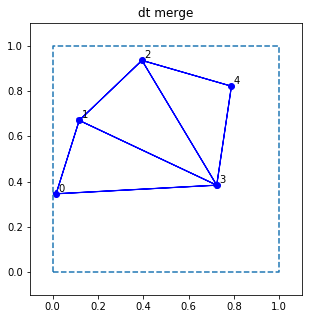

[[3, 1], [0, 3, 2], [1, 3, 4], [4, 2, 1, 0], [2, 3]]


In [85]:
pts = pointset(name="rnd5")
for o in ['plot']: pts.options.add(o)
pts.triangulate()
pts.mergeplot({'hl': 0.0})
print(pts.a)

Get the triangles in the triangulation

In [86]:
def method(self, adj=None):
    """Return list of simplices in standard order with no repeats"""
    if adj == None:
        adj = self.a

    chv = self.convexhullvertices(adj)
    t = []
    
    def consider(v):
        m = min(v)
        i = v.index(m)
        w = [ v[i+j-3] for j in range(3)]
        #print('v:{}  m:{}  i:{}  w:{}'.format(v, m, i, w))
        t.append(w)
        return

    for v0 in range(self.npoints):
        a = adj[v0]
        na = len(a)
        if na == 0:
            continue
        for j in range(1, na):
            consider([v0, a[j-1], a[j]])
        v1 = a[na-1]
        if v1 not in chv:
            consider([v0, v1, a[0]])

    t = sorted(t)
    r = [t[0]]
    for i in range(1, len(t)):
        if t[i-1] == t[i]:
            continue
        r.append(t[i])
    return r

pointset.simplices = method

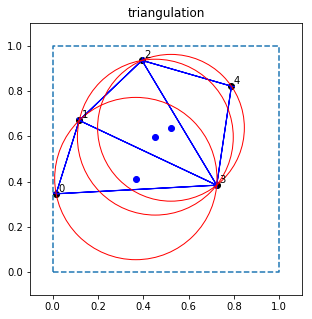

[[0, 3, 1], [1, 3, 2], [2, 3, 4]]

In [87]:
pts.plot(title='triangulation', circles=pts.simplices(), adj=True, length=0)
pts.simplices()

In [88]:
def method(self, v0, v1):
    return (self.x[v1] - self.x[v0])**2 + (self.y[v1] - self.y[v0])**2

pointset.distancesquared = method

In [89]:
def method(self, x, y, u):
    return ( (x-self.x[u])**2.0 + (y-self.y[u])**2 )**0.5

pointset.distance = method

## Findsimplex

This is a surprisingly complex method to find the simplex of a given point.
It randomly picks a few starting points and picks the closest one.
Then it moves along edges that are just clockwise relative to the point.
In the general case, once a vertex is observed again, the point must be in the simplex.
For a point on an edge, tranverse the colinear edge in both directions and pick the ccw
triangle. This works for a point on a vertex too, but any neighboring triangle might be picked.
Raises an AssertionError if the point is not in the convex hull.

In [90]:
def method(self, x, y):
    """Find a simplex that (x,y) is in. """
    starts = [i for i in range(pts.npoints) if len(pts.ha[-1][i]) > 0]
    v = sorted([ (self.distance(x, y, i), i) for i in starts ])[0][1]
    lv = -1
    llv = -1
    lc = False
    adj = self.a
    
    def std(v0, v1, v2):
        if v0 < v1:
            if v0 < v2:
                return [v0, v1, v2]
            return [v2, v0, v1]
        elif v1 < v2:
            return [v1, v2, v0]
        return [v2, v0, v1]
    
    def ccwtri(v0, v1):
        """Returns the ccw triangle with edge v0 to v1"""
        a1 = self.a[v1]
        v2 = a1[-1]
        for vp in a1:
            if vp == v0:
                break
            v2 = vp
        return std(v0, v1, v2)

    while True:
        c = False
        a = adj[v]
        f = self.cw(x, y, v, a[0])
        if f == 0:
            c = True
            if lc == True:
                return ccwtri(v, a[0])
        onesided = True
        lena = len(a)
        for j in range(1, lena):
            i = j if f != 1 else lena - j
            t = self.cw(x, y, v, a[i])
            if t == 0:
                c = True
                if lc == True:
                    return ccwtri(v, a[i])
            elif t == f:
                # same side
                continue
            nv = a[i if f == 1 else i - 1] # point is ccw of this line
            if nv == llv:
                return std(llv, lv, v)
            llv = lv
            lv = v
            v = nv
            onesided = False
            break
        lc = c
        if onesided:
            raise AssertionError('Point ({}, {}) is outside the convex hull'.format(x, y))
    return std(llv, lv, v)

pointset.findsimplex = method

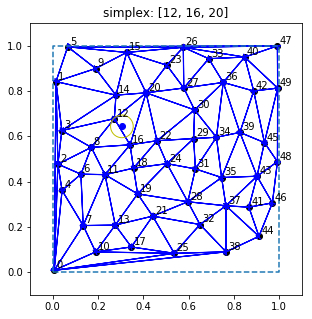

In [91]:
pts=pointset(n=50, delta=.1)
pts.options.add('plot')
pts.triangulate()

x, y = random()*.5+.25, random()*.5+.25
s1 = pts.findsimplex(x, y)
pts.plot(title='simplex: {}'.format(s1), adj=True, length=0, xyrcircles=[ [x, y, .05 ] ])

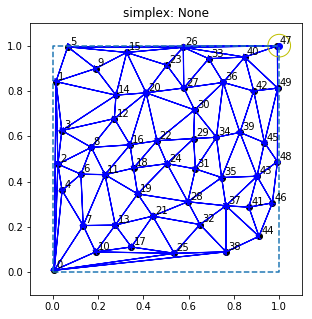

In [92]:
x, y = 1, 1
try:
    s1 = 'None'
    s1 = pts.findsimplex(x, y)
except AssertionError:
    pass
pts.plot(title='simplex: {}'.format(s1), adj=True, length=0, xyrcircles=[ [x, y, .05 ] ])

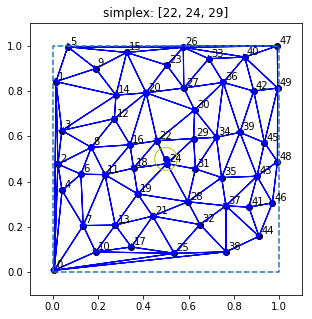

In [93]:
x,  y = 0.5, 0.5
s1 = pts.findsimplex(x, y)
pts.plot(title='simplex: {}'.format(s1), adj=True, length=0, xyrcircles=[ [x, y, .05 ] ])

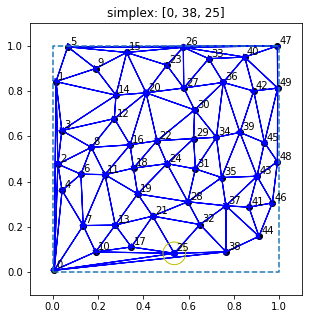

In [94]:
x, y = pts.x[pts.npoints//2], pts.y[pts.npoints//2]
s1 = pts.findsimplex(x, y)
pts.plot(title='simplex: {}'.format(s1), adj=True, length=0, xyrcircles=[ [x, y, .05 ] ])

### Graph Operations


In [95]:
def method(self):
    """Returns list of edges in standard order with no repeats"""
    chv = self.convexhullvertices()
    e = []
    
    for v0 in range(self.npoints):
        a = self.a[v0]
        for v1 in self.a[v0]:
            if v1 > v0:
                e.append([v0, v1])
    return e

pointset.edges = method

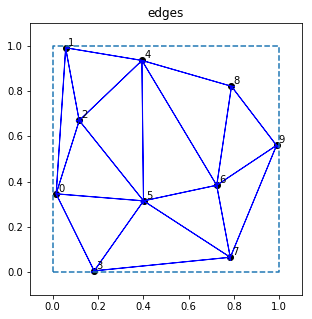

In [96]:
pts=pointset(name="rnd10")
pts.options.add('plot')
pts.triangulate()
pts.plot(title='edges', lines=pts.edges(), length=0)

In [97]:
def method(self):
    """
    Returns list of tuples of (v0, v1), vo1, vo2 in standard order with no repeats.
    
    v0 and v1 are the vertices of the common edge.
    vo1 and vo2 are the opposite vertices of the 2 adjoining faces.
    """

    s = []
    for i in range(self.npoints):
        s.append(set(self.a[i]))
    
    ef = []
    for e in self.edges():
        s0 = s[e[0]]
        s1 = s[e[1]]
        vo = s0.intersection(s1)
        ef.append([e, list(vo)])
    return ef

pointset.faces = method

In [98]:
def method(self):
    """
    Returns list of tuples of (v0, v1), (vo1, vo2) in standard order with no repeats.
    
    v0 and v1 are the vertices of the common edge.
    vo1 and vo2 are the opposite vertices of the 2 adjoining faces.
    """

    ie = []
    for e, vo in self.faces():
        if len(vo) != 2:
            continue
        ie.append([e, vo])
    return ie

pointset.interiorfaces = method

The Gabriel graph is a subset of the Delaunay triangulation.
The graph only includes edges where no other vertex is in the circle described by using the edge as its diameter.
This graph is a superset of all possible minimum span tree graphs of the triangulation.

In [99]:
def method(self):
    gg = []
    if 'log gg' in self.options:
        def log(s):
            self.log(s)
    else:
        def log(s):
            pass

    for faces in self.faces():
        e, vo = faces
        v0, v1 = e
        log('edge {}, {}'.format(v0, v1))
        flag = True
        c2 = self.distancesquared(v0, v1)
        for voi in vo:
            a2 = self.distancesquared(v0, voi)
            b2 = self.distancesquared(v1, voi)
            # c2 = a2 + b2 - 2ab cos theta
            cos_voi = (a2 + b2 - c2) / (2 * a2**0.5 * b2**0.5)
            if cos_voi < 0:
                log('  angle {} has cos of {:.3f}'.format(voi, cos_voi))
                flag = False
                break
        if flag:
            log('  angles {} are small'.format(vo))
            gg.append(e)
    return gg

pointset.gabrielgraph = method

In [100]:
def method(self, e=None, gg=None):
    if e == None:
        e = self.edges()
    elen = len(e)
    if gg == None:
        gg = pts.gabrielgraph()
    uu = gg
    for be in pts.boundaryedges(0):
        if be[0] > be[1]:
            be = [be[1], be[0]]
        if be not in uu:
            uu.append(be)
    uulen = len(uu)
    return elen == uulen

pointset.ispitteway = method

In [101]:
def method(self, u, v):
    d = self.distance(self.x[u], self.y[u], v)
    # 2*pi/(3*cost(pi/6)) < 2.42
    return 2.42 * d

pointset.maximumpathlength = method

In [102]:
def method(self, simplices=None):
    c = []
    if simplices == None:
        simplices = self.simplices()
    for s in simplices:
        c.append(self.circumcircle(s[0], s[1],s[2]))
    return c

pointset.triangulationcircumcircles = method

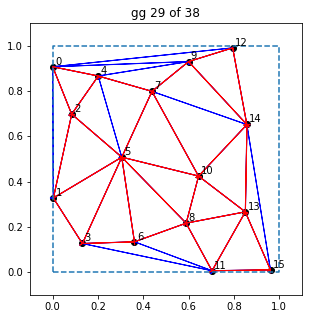

False

In [103]:
pts=pointset(n=20, delta=0.2)
pts.triangulate()
pts.options.add('plot')
ee=pts.edges()
ff = [ e for e, vo in pts.faces() ]
gg = pts.gabrielgraph()
pts.plot(title='gg {} of {}'.format(len(gg), len(ff)), lines=ff, redlines=gg, length=0)
pts.ispitteway()

In [104]:
def method(self, gg):
    """
    Find the minimum spanning tree given the edges in the pointset.
    The MST is a subset of the Gabriel graph and the Delaunay triangulation.
    
    Kruskal algorithm.
    """

    groups = dict((x, x) for x in range(self.npoints))
    sizes = dict((x, 1) for x in range(self.npoints))
    items = dict((x, [x]) for x in range(self.npoints))
    
    edges = [(u, v, self.distancesquared(u, v)**0.5) for u, v in gg]
    edges.sort(key=lambda k: (k[2], k[0], k[1]))

    mst = []
    for u, v, d in edges:
        su = groups[u]
        sv = groups[v]
        if su == sv:
            continue
        mst.append([u, v])
        if sizes[su] < sizes[sv]:
            su, sv = sv, su
        for s in items[sv]:
            groups[s] = su
            items[su].append(s)
        sizes[su] += sizes[sv]
        del items[sv]
        del sizes[sv]

    return mst

pointset.minimumspanningtree = method

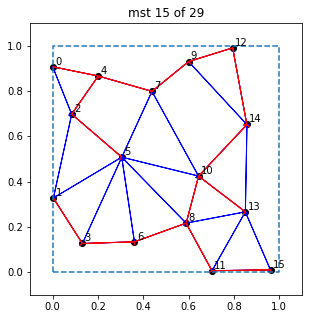

In [105]:
mst = pts.minimumspanningtree(gg)
pts.plot(title='mst {} of {}'.format(len(mst), len(gg)), lines=gg, redlines=mst, length=0)

Remove the generic function `method` to keep the namespace clean

In [106]:
del method

In [107]:
del test

## Convert notebook to Python module

Convert this notebook into a python script suitable for loading as a module.
Use `nbconvert` with `--to python` and the following configuration [options](http://nbconvert.readthedocs.io/en/latest/config_options.html):

- TemplateExporter.exclude_output=True suppresses all the output cells.
- TemplateExporter.exclude_input_prompt=True suppresses comments with the cell input number.
- TemplateExporter.exclude_markdown=True suppresses all markdown cells.
- TagRemovePreprocessor.remove_cell_tags=("test","test")' filters out the cells tagged with `test`

In [108]:
!jupyter nbconvert \
    '--TemplateExporter.exclude_output=True' \
    '--TemplateExporter.exclude_input_prompt=True' \
    '--TemplateExporter.exclude_markdown=True' \
    '--TagRemovePreprocessor.remove_cell_tags=("test","test")' \
    --to python pointset.ipynb

[NbConvertApp] Converting notebook pointset.ipynb to python
[NbConvertApp] Writing 35514 bytes to pointset.py


## Final Thoughts

The sited paper states that the triangulation algorthm is O(n log n), based on its recurvsive nature and the linear processing time of each merge. I've not tested this and I'm a little concerned about the speed of the `insert` method: on average 1/2 of the neighboring vertices must be evaluated. But as n gets large, the number of neighbors must be much less than n.

As a practical matter, checking for collinear triangles in a data set is difficult to do - especially since these could be intermediate triangles that are not in the final triangulation. **This algorithm will not work on data sets with 2 collinear degenerate triangles.** The Guibas paper details the `quad_edge` data structure which may handle this problem.

Having developed a baseline algorithm, improvements can be tested by replacing methods in the class definition.
For example, an alternative `qtest` method that has the same inputs and outputs could replace this baseline
implementation.

Additional methods for extracting the nearest neighbor, shortest path between vertices,
find the largest vertex-free circle centered in the convex hull,
Voronoi diagram & plotting method.

Additional method for adding an additional vertex to the existing triangulation.
Outline:
determine the triangle that it is in,
Connect point to the 3 vertices,
push the 3 existing edges onto a suspect stack,
pop edge off suspect stack,
test quadralateral using qtest,
if bad edge then remove edge add other edge and push 2 opposite edges onto suspect stack,
repeat until stack is empty.

Is there a way to delete a vertex?
Outline:
delete the vertex,
delete all lines connected to the vertex,
consider all triples q1, q2, q3 in ccw direction,
skip cw q1 q2 q3,
pushd line q1 q3 onto a suspect stack,
consider next triple starting at q3 until done,
process suspect stack as above.
